# Задача

Написать классификатор коротких текстов, оценить его точность, проанализировать ошибки и предложить способы их устранения.

Предлагаемый алгоритм:
1. нормализовать тексты с помощью mystem
2. построить вектора unigram и bigram с TF-IDF весами
3. обучить классификатор на основе SVM или нейронной сети (1 входной слой, 1 выходной softmax слой)

Собственно алгоритм классификации может быть любым другим.

Общий подход:
1. реализовать классификатор
2. провести анализ точности (accuracy)
3. проанализировать ошибки, выдаваемые классификатором (построить confusion matrix и проанализировать его)
4. предложить способы их устранения

In [103]:
from pymystem3 import Mystem

from time import time
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import VotingClassifier

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
def classification_report(predictions,test_y,classes):
    print("Classification report:")
    print(metrics.classification_report(test_y, predictions,target_names=classes,digits=3))

    cm = metrics.confusion_matrix(test_y, predictions)

    matplotlib.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

def test_classifier(classifier,train_x, train_y, test_x, test_y,classes, show=False):
    def inner_log(*args):
        if show == True:
            print(" ".join([str(x) for x in args]))
    def inner_md(s):
        if show == True:
            printmd(s)
    
    clf_descr = str(classifier).split('(')[0]
    inner_md("**Classifier:%s**" % clf_descr)
    inner_log("Info:",classifier)
    
    inner_log("Trainig...")
    t0 = time()
    classifier.fit(train_x, train_y)
    train_time = time() - t0
    inner_log("Train time: %0.3fs" % train_time)

    inner_log("Testing...")
    t0 = time()
    if clf_descr == "XGBClassifier":
        # Bag in XGB with sparse vectors     
        predictions = classifier.predict(test_x.toarray())
    else:
        predictions = classifier.predict(test_x)
    test_time = time() - t0
    inner_log("Test time:%0.3fs" % test_time)

    score = metrics.accuracy_score(test_y, predictions)
    inner_md("**Accuracy:%0.3f**" % score)
    
    if show == True:
        classification_report(predictions,test_y,classes)
          
    return clf_descr, score, train_time, test_time


 # Чтение данных

In [3]:
key_df = pd.read_csv('KEY.tsv', sep='\t')
other_df = pd.read_csv('OTHER.tsv', sep='\t')
s1 = set(other_df["label"])
s2 = set(key_df["label"])
assert(s1 == s2)
topic_set = s1

# Приведение к нормальной форме

In [4]:
# normalization
m = Mystem()

def normilize_text(text):
    lemmas = m.lemmatize(text)
    return ''.join(lemmas).replace('\n','')
v_normilize_text = np.vectorize(normilize_text)

key_df = key_df.apply(v_normilize_text)
other_df = other_df.apply(v_normilize_text)


topic_to_index = {}
topics = []
topics_orig = []
for i, key in enumerate(topic_set):
    nkey = normilize_text(key)
    topics.append(nkey)
    topics_orig.append(key)
    topic_to_index[nkey] = i

# Подсчёт tf-idf для (1,2) грамм

Тексты короткие на всякий случай решил сделать для двух вариантов:
1. tf-idf для вектора из словестных униграм и биграм
2. tf-idf для вектора только из словестных униграм 

In [5]:
tf_12 = TfidfVectorizer(analyzer='word',use_idf=True, ngram_range=(1,2))
tf_11 = TfidfVectorizer(analyzer='word',use_idf=True, ngram_range=(1,1))
train_texts = key_df["text"].values
train_labels = key_df["label"].values
test_texts = other_df["text"].values
test_labels = other_df["label"].values

train_y = [topic_to_index[k] for k in train_labels.tolist()]
test_y = [topic_to_index[k] for k in test_labels.tolist()]

train_12_x =  tf_12.fit_transform(train_texts)
train_11_x =  tf_11.fit_transform(train_texts)

test_12_x = tf_12.transform(test_texts)
test_11_x = tf_11.transform(test_texts)

feature_names_12 = tf_12.get_feature_names() 
feature_names_11 = tf_11.get_feature_names() 
print("tf-idf (1,2)gram")
print("Train shape:",train_12_x.shape)
print("10 features:",feature_names_12[0:10])

print("tf-idf (1)gram")
print("Train shape:",train_11_x.shape)
print("10 features:",feature_names_11[0:10])

tf-idf (1,2)gram
Train shape: (50, 524)
10 features: ['dns', 'dns сервер', 'fi', 'fi не', 'sms', 'sms какой', 'wi', 'wi fi', 'абонентский', 'абонентский плата']
tf-idf (1)gram
Train shape: (50, 191)
10 features: ['dns', 'fi', 'sms', 'wi', 'абонентский', 'аварийный', 'беспокоить', 'будто', 'бы', 'быть']


# Провекрка методов классификации для вектора из униграм и биграм

Проверяю для следующих классификаторов:
1. SVM с линейным ядром.
2. Нейронная сеть со скрытым слоем из 80и нейронов и sofmax выходным слоем.
3. Случайный лес.


**Classifier:SVC**

Info: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Trainig...
Train time: 0.003s
Testing...
Test time:0.031s


**Accuracy:0.396**

Classification report:
                                precision    recall  f1-score   support

неисправность телефонной связи      0.631     0.350     0.451      1230
                      интернет      0.196     0.570     0.291       179
       неисправность интернета      0.337     0.420     0.374       789
                  оплата услуг      0.530     0.247     0.337       676
            приостановка услуг      0.240     0.392     0.298       171
     неисправность телевидения      0.693     0.466     0.557       247
      информация по квитанциям      0.291     0.746     0.418       173
         подключение интернета      0.362     0.574     0.444       162
                 задолженность      0.303     0.619     0.407       197
                  техподдержка      0.564     0.309     0.399       499

                   avg / total      0.485     0.396     0.403      4323



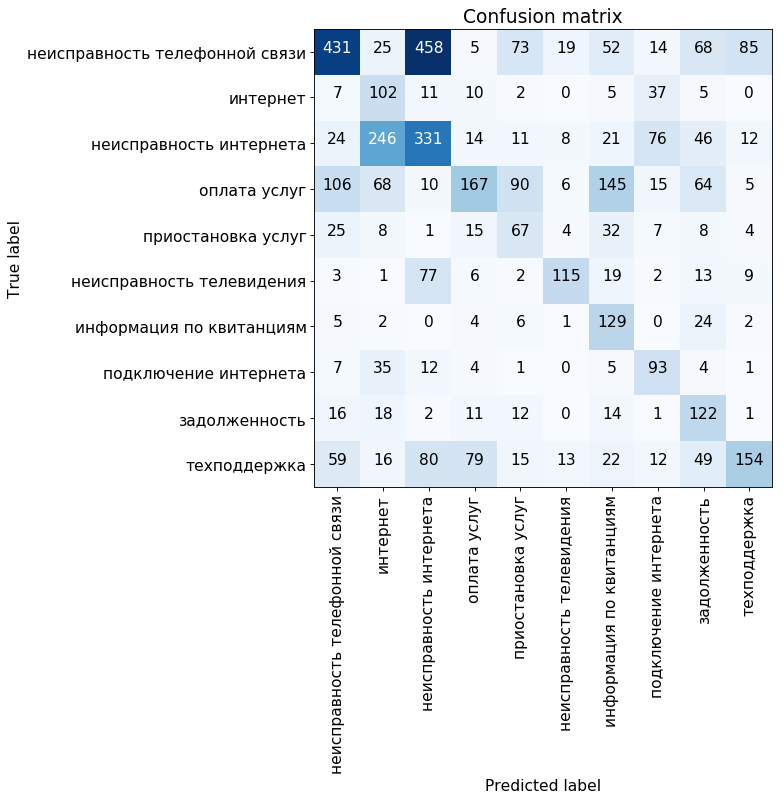

0.3958 SVC


**Classifier:MLPClassifier**

Info: MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=80, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
Trainig...
Train time: 0.128s
Testing...
Test time:0.013s


**Accuracy:0.373**

Classification report:
                                precision    recall  f1-score   support

неисправность телефонной связи      0.741     0.323     0.450      1230
                      интернет      0.232     0.676     0.346       179
       неисправность интернета      0.356     0.422     0.386       789
                  оплата услуг      0.757     0.120     0.207       676
            приостановка услуг      0.165     0.532     0.251       171
     неисправность телевидения      0.847     0.336     0.481       247
      информация по квитанциям      0.267     0.682     0.384       173
         подключение интернета      0.485     0.500     0.492       162
                 задолженность      0.210     0.782     0.331       197
                  техподдержка      0.672     0.309     0.423       499

                   avg / total      0.575     0.373     0.380      4323



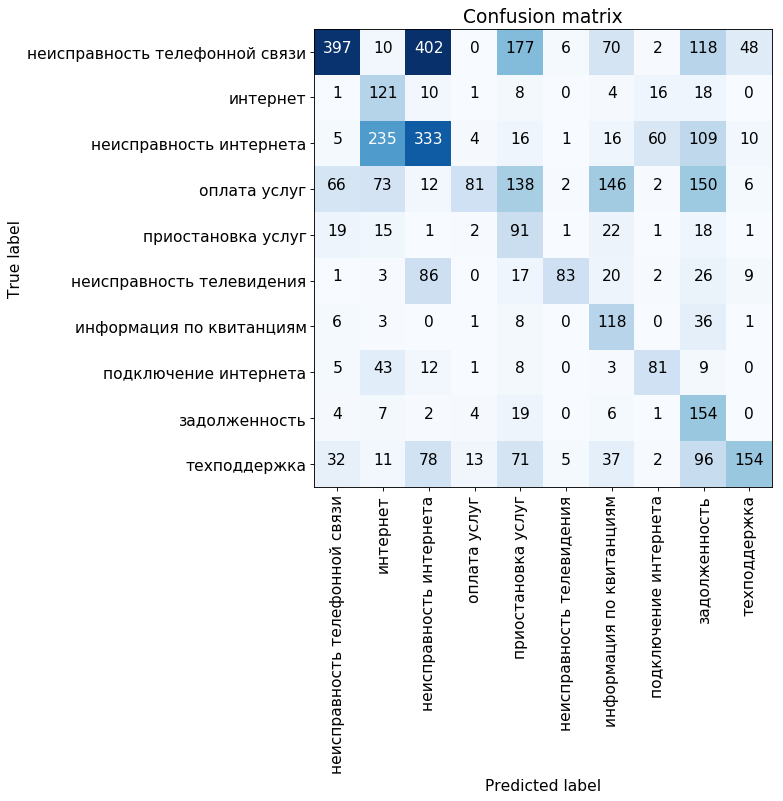

0.3731 MLPClassifier


**Classifier:RandomForestClassifier**

Info: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
Trainig...
Train time: 0.305s
Testing...
Test time:0.180s


**Accuracy:0.263**

Classification report:
                                precision    recall  f1-score   support

неисправность телефонной связи      0.712     0.128     0.218      1230
                      интернет      0.168     0.385     0.234       179
       неисправность интернета      0.254     0.305     0.277       789
                  оплата услуг      0.467     0.368     0.412       676
            приостановка услуг      0.081     0.825     0.148       171
     неисправность телевидения      0.892     0.235     0.372       247
      информация по квитанциям      0.552     0.462     0.503       173
         подключение интернета      0.472     0.463     0.467       162
                 задолженность      0.500     0.086     0.147       197
                  техподдержка      0.649     0.096     0.168       499

                   avg / total      0.520     0.263     0.277      4323



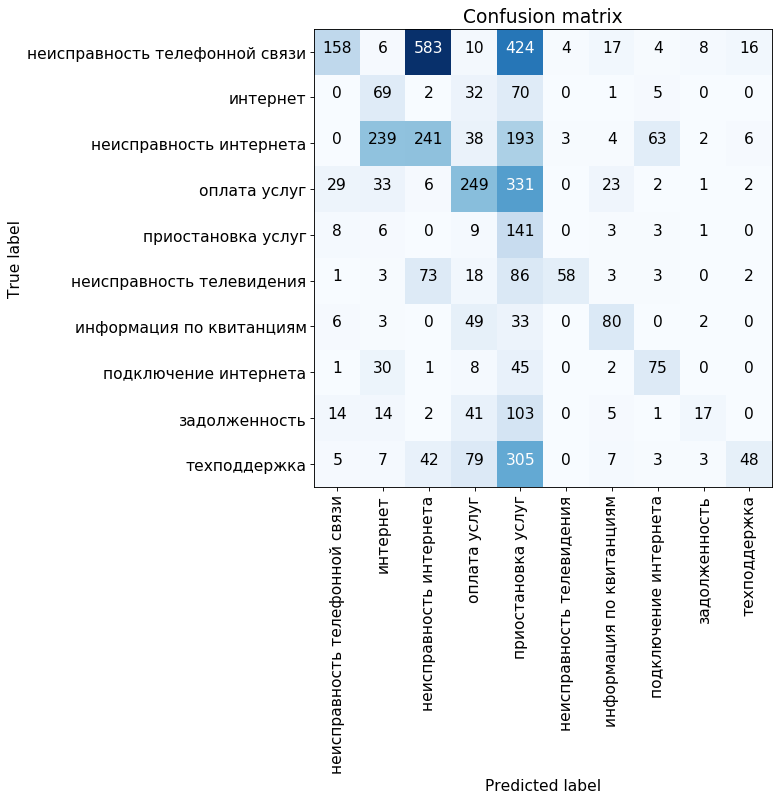

0.2628 RandomForestClassifier


In [127]:
clfs = [
svm.SVC(kernel='linear'),
MLPClassifier(solver='lbfgs', activation='tanh', alpha=0.00001, hidden_layer_sizes=(80), random_state=1),
RandomForestClassifier(n_estimators=200,random_state=1)
]

show = True

for clf in clfs:
    cn, score,trt, tst = test_classifier(clf,train_12_x,train_y, test_12_x, test_y,topics_orig,show=show)
    print("%0.4f" % score, cn)

# Вывод 
Исходные классификаторы раюботют не очень хорошо, точность между 30-40%. 

Вероятные причины:
- Малый размер обучающей выборки 50 против тестовой 4324. В следствии чего переобучение.
- Неоправданный подход к выбору фичь, при (1,2) граммах вектор состоит из 524 элементов. Не вижу причин ожидать, что такой большой вектор сможет представлять что-то осмысленное при обучающей выборке состоящей из пяти предложений на каждую из десяти тем, при примерном размерер предложения в 20 слов.

Предложения:
Нужно уменьшать количество фичей или добывать дополнительную информацию.

Далее предложены два подхода.

# 1. Просто уменьшим количество фичей. Возьмём толкьо униграммы, попробуем выбрать несколько самых информативных.

In [128]:

show = False
    
print("tf-idf (1)gram")
for clf in clfs:
    cn, score,trt, tst = test_classifier(clf,train_11_x,train_y, test_11_x, test_y,topics_orig,show=show)
    print("%0.4f" % score, cn)
    
k = 50
print("Best:",k)
ch2 = SelectKBest(chi2, k=k)
train_12_kbest_x = ch2.fit_transform(train_12_x, train_y)
test_12_kbest_x = ch2.transform(test_12_x) 
# print("Best K for (1,2):",ch2.transform(feature_names_12)[0:5])

ch2 = SelectKBest(chi2, k=k)
train_11_kbest_x = ch2.fit_transform(train_11_x, train_y)
test_11_kbest_x = ch2.transform(test_11_x)    
# print("Best K for (1):",ch2.transform(feature_names_11)[0:5])


print("tf-idf only k best (1,2)gram")
for clf in clfs:
    cn, score,trt, tst = test_classifier(clf,train_12_kbest_x,train_y, test_12_kbest_x, test_y,topics_orig,show=show)
    print("%0.4f" % score, cn)
    
print("tf-idf only k best (1)gram")
for clf in clfs:
    cn, score,trt, tst = test_classifier(clf,train_11_kbest_x,train_y, test_11_kbest_x, test_y,topics_orig,show=show)
    print("%0.4f" % score, cn)
    


tf-idf (1)gram
0.4599 SVC
0.4555 MLPClassifier
0.3396 RandomForestClassifier
Best: 50
tf-idf only k best (1,2)gram
0.2787 SVC
0.4883 MLPClassifier
0.3930 RandomForestClassifier
tf-idf only k best (1)gram
0.4448 SVC
0.4816 MLPClassifier
0.5034 RandomForestClassifier


Удалось достичь 50%. 

# 2. Без применения сложных методов.

По сути у нас есть условный "документ", это наша тема из обучающей выборки состоящая из пяти предложений. Хотим определить принадлежность текста из тестовой выборки к документам. Воспользуемся класическим методом из информационного поиска tf-idf +  cosine distance.

In [133]:
# Собираем все предложения однйо темы в один корпус, для каждой темы получится документ из предложений.
full_text_by_topic = [""] * len(topic_set)
train_full_text_y = [x for x in range(len(topic_set))]
for i,cls in enumerate(train_y):
    full_text_by_topic[cls] = full_text_by_topic[cls] + train_texts[i] + " "
# В массиве full_text_by_topic теперь лежат склееные предложения, индекс соответсвует теме. 
    

# tf-idf 
tf_full_text = TfidfVectorizer(analyzer='word',use_idf=True, ngram_range=(1,1))
# Создаём векторное представление документов
train_full_text_x =  tf_full_text.fit_transform(full_text_by_topic)
# print("Train shape:",train_full_text_x.shape)
# Создаём векторное представление всех тестовых предложений
test_full_text_x = tf_full_text.transform(test_texts)
# print("Test shape:",test_full_text_x.shape)
# Просто демонстрация первых 10 фичей
feature_names_full_text = tf_full_text.get_feature_names() 
# print("10 features:",feature_names_full_text[0:10])


k = 112 
# print("Best:",k)
ch2 = SelectKBest(chi2, k=k)

train_full_text_x = ch2.fit_transform(train_full_text_x, train_full_text_y)
test_full_text_x = ch2.transform(test_full_text_x) 

# Предсказываем просто находя ближайши к предложенному тексту документ по косинусному растоянию.
tf_cos_predictions = np.argmax(cosine_similarity(test_full_text_x,train_full_text_x), axis=1)

# Считаем точность
score = metrics.accuracy_score(test_y, tf_cos_predictions)

printmd("**Accuracy:%0.3f**" % score)

# Отчёт по ошибкам
# classification_report(predictions,test_y,topics_orig)



**Accuracy:0.481**

48% неплохо для метода без ML.

# Голосование классификаторов

При наализе confusion matrix видно что у методов бывают разные ошибки,поэтому поробуем получить луший классификатор обычным голосованием.

In [132]:
clf1 = svm.SVC(kernel='linear')
clf2 = MLPClassifier(solver='lbfgs', activation='tanh', alpha=0.00001, hidden_layer_sizes=(80), random_state=1)
clf3 = RandomForestClassifier(n_estimators=200,random_state=1)

clf1.fit(train_11_x,train_y)
clf2.fit(train_11_kbest_x,train_y)
clf3.fit(train_11_kbest_x,train_y)

pr1 = clf1.predict(test_11_x)
pr2 = clf2.predict(test_11_kbest_x)
pr3 = clf3.predict(test_11_kbest_x)

voting_result = np.zeros_like(test_y)
# for 
for i in range(len(test_y)):
    arr = np.zeros(10)
    arr[pr1[i]] +=1
    arr[pr2[i]] +=1
    arr[pr3[i]] +=1
    arr[tf_cos_predictions[i]] += 1
    voting_result[i] = np.argmax(arr)
                  
# Считаем точность
score = metrics.accuracy_score(test_y, voting_result)

printmd("**Accuracy:%0.3f**" % score)


**Accuracy:0.515**

51% Чуть лучше. Однако замер производится без оценки дисперсии, по хорошему нужно наладить паплайн и смотреть устойчивость решения, но в задаче это не требовалось.

# Гипотезы по улучшению классификатора для дальнейшей проверки

1. Из confusion matrix видно что есть ошибки на схожих темах например (интернет/неисправность интернет).Можно попробоват научить наш классификатор верхнего уровня определять общую тематику для таких случаев "интернет общее" и далее обучить отдельный классификатор для разделения по подтемам. 
2. Можно попробовать создать фичи используя word2vec
3. Если будет возможность увеличить тестовую выборку можно попробовать классификацию через рекурентные нейросети.